# KYC: know your collegues (based on OpenFace & FaceNet)

In [1]:
import os
import cv2
import pickle
import glob
import numpy as np
import pandas as pd
import skimage.transform as tr
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras import backend as K
from keras.models import load_model
from cnn import get_model, load_weights
print('available devices: ', [x.name for x in K.tensorflow_backend.device_lib.list_local_devices()])

Using TensorFlow backend.


available devices:  ['/device:CPU:0', '/device:GPU:0']


In [2]:
%%time
IMG_SIZE = 96
DATA_PATH = './data/'
HAAR_FILTER_PATH = '{}{}'.format(cv2.data.haarcascades,  'haarcascade_frontalface_default.xml')
CV_DETECTOR = cv2.CascadeClassifier(HAAR_FILTER_PATH)
LEVEL = .75

Wall time: 25.6 ms


### 1. Recognition utils

In [3]:
def get_face_xywh(face_rect):
    x = face_rect.left()
    y = face_rect.top()
    w = face_rect.right() - x
    h = face_rect.bottom() - y
    return (x, y, w, h)
def image_to_embedding(image, model):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) 
    img = image[..., ::-1]
    img = np.around(np.transpose(img, (0, 1, 2)) / 255., decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding
def find_identity(img, database, model, level=.75):
    min_dist = 100.
    identity = None
    img_embedding = image_to_embedding(img, model)
    for (label, data) in database.items():
        dist = np.linalg.norm(data[4] - img_embedding)
        if dist < min_dist:
            min_dist = dist
            identity = data[0]
    if min_dist < level:
        return identity, min_dist
    else:
        return None, min_dist
def find_faces_img(img, database, model):
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    font_scale = max(img.shape[0], img.shape[0]) / 700
    line_scale = round(3 * font_scale)
    shift_x = 5
    shift_y = int(shift_x * font_scale)
    img_cv = img.copy()
    try:
        img_cv = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = CV_DETECTOR.detectMultiScale(img_cv, scaleFactor=1.5, minNeighbors=5)
    except:
        faces = []
    for (x, y, w, h) in faces:
        img_face = img[y:y + h, x:x + w, :]
        identity, min_dist = find_identity(img_face, database, model, level=LEVEL)
        print(identity, min_dist, LEVEL)
        if identity:
            img = cv2.rectangle(img, (x, y), (x + w, y + h), color, line_scale)
            cv2.putText(img, str(identity), (x + shift_x, y - shift_y), font, font_scale, color, line_scale)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### 1. Loading CNN and pretrained weights

In [4]:
%%time
#---load model, weigths and save if needed---
#model = get_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))
#load weights if needed and save
#model = load_weights(model)
#model.save('./data/model.h5')
#---load trained model---
model = load_model('./data/model.h5', custom_objects={'tf': tf})

C:\Users\vgarshin\Anaconda3\lib\site-packages\keras\engine\saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Wall time: 3.9 s


### 3. Create database of identities

In [5]:
def translit(text):
    symbols = ('абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ',
               'abvgdeejzijklmnoprstufhccss_yieuaABVGDEEJZIJKLMNOPRSTUFHCCSS_YIEUA ')
    tr = {ord(a):ord(b) for a, b in zip(*symbols)}
    return text.translate(tr)
def get_database(database, model, path='./photos'):
    label = 900000
    files = os.listdir(path)
    print(files)
    for file in tqdm(files):
        label += 1 
        name = os.path.splitext(os.path.basename(file))[0]
        department, subject = 'Updated', 'Updated'
        path_file = '{}/{}'.format(path, file)
        upd_img = cv2.imread(path_file, 1)
        img_cv = upd_img.copy()
        try:
            img_cv = cv2.cvtColor(upd_img, cv2.COLOR_BGR2GRAY)
            faces = CV_DETECTOR.detectMultiScale(img_cv, scaleFactor=1.2, minNeighbors=6)
        except:
            faces = []
        for (x, y, w, h) in faces:
            img_face = upd_img[y:y + h, x:x + w, :]
            database[label] = (name, department, subject, path_file, image_to_embedding(img_face, model))
    return database

In [6]:
%%time
#---prepare base---
database = {}
database = get_database(database, model, path='./photos')
#---save to disk---
with open('./data/database_cv.pkl', 'wb') as file:
    pickle.dump(database, file)
#---load full base and filter by condition---
with open('./data/database_cv.pkl', 'rb') as file:
    database = pickle.load(file)

['Andrey Koceruba.jpg', 'Vasiliy Garshin.jpg']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.41s/it]


Wall time: 3.71 s


### 4. Find face on arbitary picture

Vasiliy Garshin 0.67874473 0.75
None 1.0666035 0.75
None 0.92989427 0.75
None 0.86308867 0.75


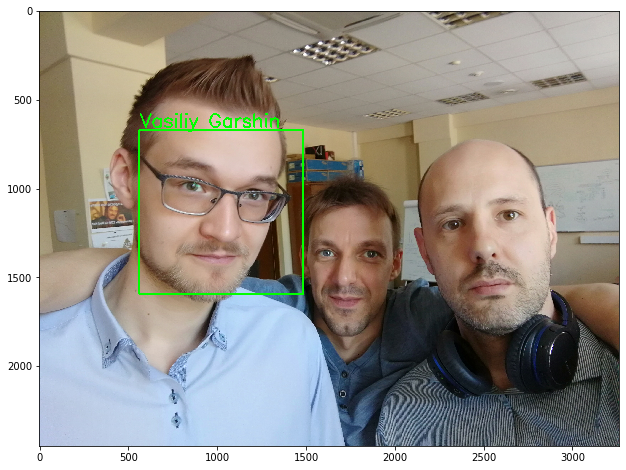

(2448, 3264, 3)
Wall time: 1.17 s


In [7]:
%%time
photo_path = './shots/*'
photo_files = glob.glob(photo_path)
test_img = photo_files[1]
img = cv2.imread(test_img)
img_proc = find_faces_img(img, database, model)
plt.figure(figsize=(16, 8))
plt.imshow(img_proc)
plt.show()
print(img_proc.shape)